# Nova Scotia Power Energy Demand Forecasting For 2025

### Data Ingestion and Cleaning

In [1]:
#Import Libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [2]:
# Read Data For 2022-2024

data_2022=pd.read_csv(r"C:\Users\USER\Downloads\2022---NSPI-hourly-loads-report-for-NBP-SOdd31c644-318f-47da-aec8-749508b9470a.csv",skiprows=2,usecols=["Date/time","Load [MW]"])

data_2023=pd.read_csv(r"C:\Users\USER\Downloads\2023---NSPI-hourly-loads-report-for-NBP-SO.csv",skiprows=2,usecols=["Date/time","Load [MW]"])

data_2024=pd.read_csv(r"C:\Users\USER\Downloads\2024---NSPI-hourly-loads-report-for-NBP-SO(CSV) (1).csv",skiprows=2,usecols=["Date/time","Load [MW]"])

data_2024


,Date/time,Load [MW]
0,NaN,NaN
1,2024-01-01 01:00,1472.10
2,2024-01-01 02:00,1446.02
3,2024-01-01 03:00,1421.85
4,2024-01-01 04:00,1408.93
...,...,...
65527,NaN,NaN
65528,NaN,NaN
65529,NaN,NaN
65530,NaN,NaN


In [3]:
data_2022.dropna(subset=["Date/time","Load [MW]"],inplace=True)
data_2023.dropna(subset=["Date/time","Load [MW]"],inplace=True)
data_2024.dropna(subset=["Date/time","Load [MW]"],inplace=True)

In [4]:
data_2024

,Date/time,Load [MW]
1,2024-01-01 01:00,1472.10
2,2024-01-01 02:00,1446.02
3,2024-01-01 03:00,1421.85
4,2024-01-01 04:00,1408.93
5,2024-01-01 05:00,1408.98
...,...,...
8780,2024-12-31 20:00,1387.15
8781,2024-12-31 21:00,1349.63
8782,2024-12-31 22:00,1321.17
8783,2024-12-31 23:00,1311.51


In [5]:
#Merge all three data sets
frames = [data_2022, data_2023, data_2024]
result = pd.concat(frames)
result

,Date/time,Load [MW]
1,2022-01-01 01:00,1289.44
2,2022-01-01 02:00,1297.40
3,2022-01-01 03:00,1253.83
4,2022-01-01 04:00,1225.03
5,2022-01-01 05:00,1215.07
...,...,...
8780,2024-12-31 20:00,1387.15
8781,2024-12-31 21:00,1349.63
8782,2024-12-31 22:00,1321.17
8783,2024-12-31 23:00,1311.51


In [6]:
result.isnull().sum()

Date/time    0
Load [MW]    0
dtype: int64

In [7]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26304 entries, 1 to 8784
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date/time  26304 non-null  object 
 1   Load [MW]  26304 non-null  float64
dtypes: float64(1), object(1)
memory usage: 616.5+ KB


In [8]:
#change Date/time to datetime format
result["Date/time"]=pd.to_datetime(result["Date/time"],format="mixed")

In [9]:
result["Date/time"]

1      2022-01-01 01:00:00
2      2022-01-01 02:00:00
3      2022-01-01 03:00:00
4      2022-01-01 04:00:00
5      2022-01-01 05:00:00
               ...        
8780   2024-12-31 20:00:00
8781   2024-12-31 21:00:00
8782   2024-12-31 22:00:00
8783   2024-12-31 23:00:00
8784   2024-12-31 00:00:00
Name: Date/time, Length: 26304, dtype: datetime64[ns]

### Exploratory Data Analysis

In [10]:
df=result.copy()
df1=df.copy()

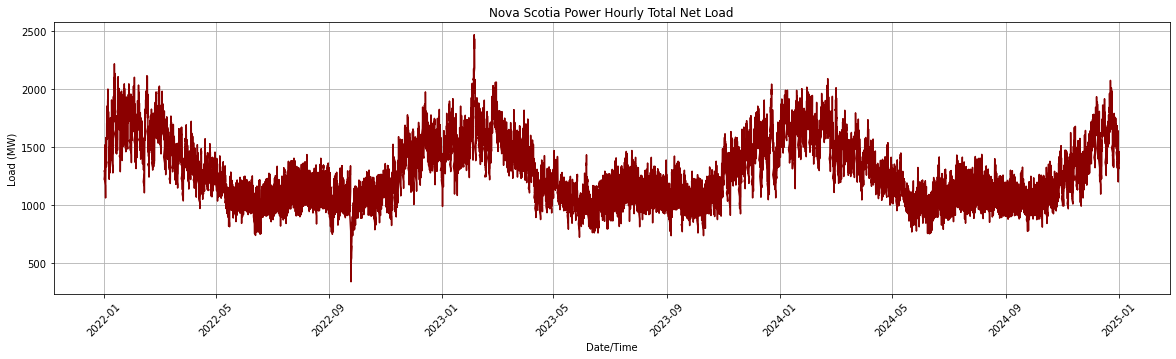

In [11]:
# Convert to numpy arrays
dates = df['Date/time'].to_numpy()
load = df['Load [MW]'].to_numpy()

# Create the figure
plt.figure(figsize=(20, 5))

# Plot the data
plt.plot(dates, load, color='DarkRed')

# Adding the title and labels
plt.title('Nova Scotia Power Hourly Total Net Load')
plt.xlabel('Date/Time')
plt.ylabel('Load (MW)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Optional: Adding gridlines
plt.grid(True)

# Show the plot
plt.show()

Demand is seasonal with peaks in winter months. Noticeably, it is stationary i.e. there is no visible upward/downward trend.

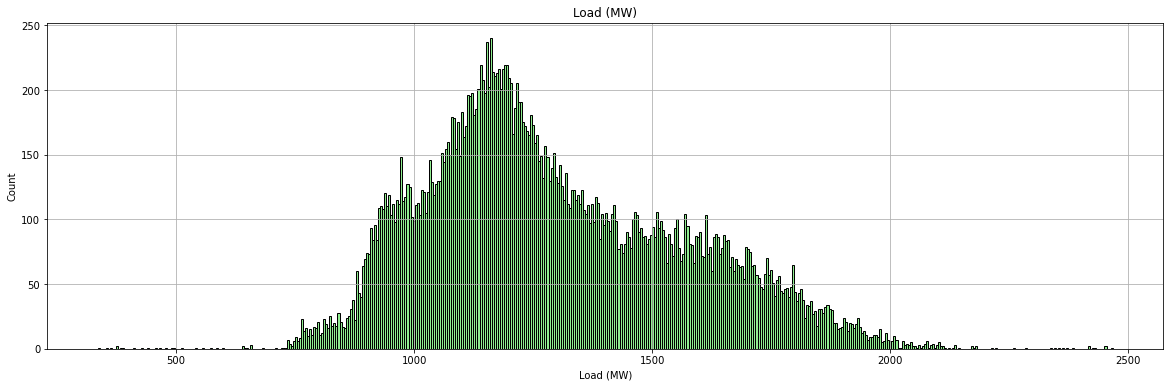

In [12]:
plt.figure(figsize=(20,6))
plt.hist(load,bins=500,color='lightgreen',edgecolor='black')
plt.title("Load (MW)")
plt.xlabel('Load (MW)')
plt.ylabel('Count')

# Optional: Adding gridlines
plt.grid(True)

# Show the plot
plt.show()

Demand tends to hover around 1200 MW.

### Demand Foreasting

NameError: name 'pyplot' is not defined

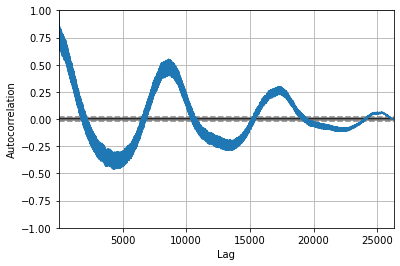

In [13]:
#Auto correlation Plot
autocorrelation_plot(load)
pyplot.show()

The ACF exhibits a wave-like pattern, alternating between positive and negative correlations. This suggests the presence of seasonality or cyclic patterns in the data.The oscillations could be due to hourly, daily or weekly demand cycles.The autocorrelation slowly declines but does not disappear immediately. This implies that the time series exhibits long-term dependencies, meaning past values continue to influence future values even at longer lags.

In [14]:
df=df.set_index("Date/time")

In [15]:
df.index

DatetimeIndex(['2022-01-01 01:00:00', '2022-01-01 02:00:00',
               '2022-01-01 03:00:00', '2022-01-01 04:00:00',
               '2022-01-01 05:00:00', '2022-01-01 06:00:00',
               '2022-01-01 07:00:00', '2022-01-01 08:00:00',
               '2022-01-01 09:00:00', '2022-01-01 10:00:00',
               ...
               '2024-12-31 15:00:00', '2024-12-31 16:00:00',
               '2024-12-31 17:00:00', '2024-12-31 18:00:00',
               '2024-12-31 19:00:00', '2024-12-31 20:00:00',
               '2024-12-31 21:00:00', '2024-12-31 22:00:00',
               '2024-12-31 23:00:00', '2024-12-31 00:00:00'],
              dtype='datetime64[ns]', name='Date/time', length=26304, freq=None)

### Train/Test Split

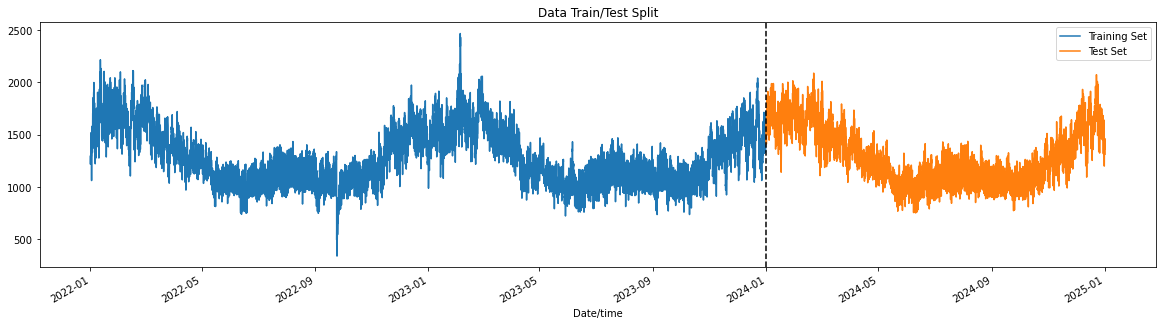

In [16]:
train = df.loc[df.index < '2024-01-01 00:00:00']
test = df.loc[df.index >= '2024-01-01 00:00:00']

fig, ax = plt.subplots(figsize=(20, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('2024-01-01 00:00:00', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

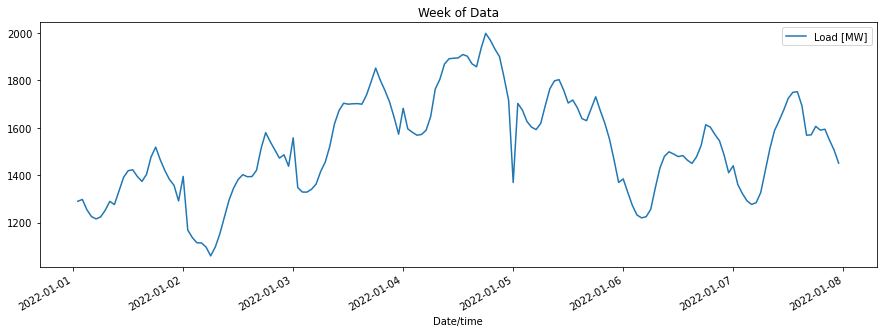

In [17]:
df.loc[(df.index > '2022-01-01 00:00:00') &(df.index < '2022-01-08 00:00:00')].plot(figsize=(15,5),title="Week of Data")
plt.show()

### Feature Creation

In [18]:
# Create function to return date/time by features

def create_features(df):
    
    df=df.copy()
    df["Hour"]=df.index.hour
    df["Day Of Week"]=df.index.dayofweek
    df["Quarter"]=df.index.quarter
    df["Month"]=df.index.month
    df["Year"]=df.index.year
    df["Day Of Year"]=df.index.dayofyear
    return df
df=create_features(df)
df

,Load [MW],Hour,Day Of Week,Quarter,Month,Year,Day Of Year
Date/time,,,,,,,
2022-01-01 01:00:00,1289.44,1,5,1,1,2022,1
2022-01-01 02:00:00,1297.40,2,5,1,1,2022,1
2022-01-01 03:00:00,1253.83,3,5,1,1,2022,1
2022-01-01 04:00:00,1225.03,4,5,1,1,2022,1
2022-01-01 05:00:00,1215.07,5,5,1,1,2022,1
...,...,...,...,...,...,...,...
2024-12-31 20:00:00,1387.15,20,1,4,12,2024,366
2024-12-31 21:00:00,1349.63,21,1,4,12,2024,366
2024-12-31 22:00:00,1321.17,22,1,4,12,2024,366


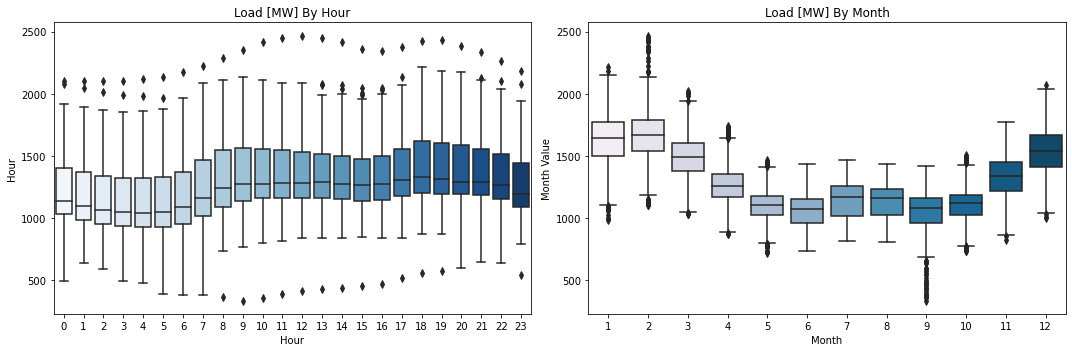

In [19]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.boxplot(data=df,x="Hour",y="Load [MW]",palette="Blues")
plt.title("Load [MW] By Hour")
plt.ylabel('Hour')


plt.subplot(1,2,2)
sns.boxplot(data=df,x="Month",y="Load [MW]",palette="PuBu")
plt.title("Load [MW] By Month")
plt.ylabel('Month Value')

plt.tight_layout()
plt.show()

Daily trends show that energy load tends to peak at around 8:00 am in the morning and again at around 6:00 pm in the evening possibly due to residential consumption. Noticeably monthly demand tend to show a major peak in winter (Dec-Mar) and a minor one in the summer (July-Sep).The hourly graph tends to have a high min/max and high outliers as well probably due to emergencies and events. Both February and September tend to have high outliersas they represent the peakof both winter and Summer. 

### Model Creation

In [20]:
train=create_features(train)
test=create_features(test)

In [21]:
df.columns

Index(['Load [MW]', 'Hour', 'Day Of Week', 'Quarter', 'Month', 'Year',
       'Day Of Year'],
      dtype='object')

In [22]:
FEATURES=['Hour', 'Day Of Week', 'Quarter', 'Month', 'Year','Day Of Year']
TARGET=['Load [MW]']

In [23]:
X_train=train[FEATURES]
y_train=train[TARGET]

X_test=test[FEATURES]
y_test=test[TARGET]

In [24]:
reg=xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50,learning_rate=0.01)
reg.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],verbose=50)

[0]	validation_0-rmse:264.71809	validation_1-rmse:269.75912
[50]	validation_0-rmse:183.29323	validation_1-rmse:193.69284
[100]	validation_0-rmse:139.66061	validation_1-rmse:154.91512
[150]	validation_0-rmse:116.74921	validation_1-rmse:136.55986
[200]	validation_0-rmse:103.70506	validation_1-rmse:129.27794
[250]	validation_0-rmse:95.82702	validation_1-rmse:125.90028
[300]	validation_0-rmse:90.16368	validation_1-rmse:125.21821
[347]	validation_0-rmse:85.37200	validation_1-rmse:125.64235


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Root mean square is the method used to measure accuracy as it heavily punish over-fitting leading to a much more accurate prediction.

<AxesSubplot:title={'center':'Feature Importance'}>

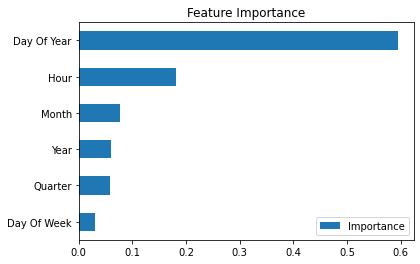

In [25]:
feature_importance=pd.DataFrame(data=reg.feature_importances_,
            index=reg.feature_names_in_,
            columns=["Importance"])

feature_importance.sort_values("Importance").plot(kind="barh",title="Feature Importance")

The feature that seems to have the most impact on overall prediction is the day of the year by a huge margin.

### Forecast 2024

In [26]:
test["prediction"]=reg.predict(X_test)

In [27]:
df=df.merge(test[["prediction"]],how="left",left_index=True,right_index=True)
df

,Load [MW],Hour,Day Of Week,Quarter,Month,Year,Day Of Year,prediction
Date/time,,,,,,,,
2022-01-01 00:00:00,1221.40,0,5,1,1,2022,1,NaN
2022-01-01 01:00:00,1289.44,1,5,1,1,2022,1,NaN
2022-01-01 02:00:00,1297.40,2,5,1,1,2022,1,NaN
2022-01-01 03:00:00,1253.83,3,5,1,1,2022,1,NaN
2022-01-01 04:00:00,1225.03,4,5,1,1,2022,1,NaN
...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,1431.25,19,1,4,12,2024,366,1525.853638
2024-12-31 20:00:00,1387.15,20,1,4,12,2024,366,1511.605835
2024-12-31 21:00:00,1349.63,21,1,4,12,2024,366,1494.493042


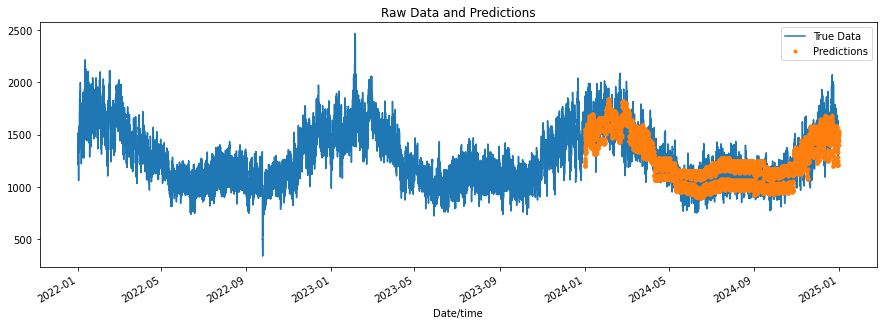

In [28]:
ax=df[["Load [MW]"]].plot(figsize=(15,5))
df['prediction'].plot(ax=ax,style='.')
plt.legend(["True Data", "Predictions"])
ax.set_title("Raw Data and Predictions")
plt.legend(["True Data", "Predictions"])
plt.show()

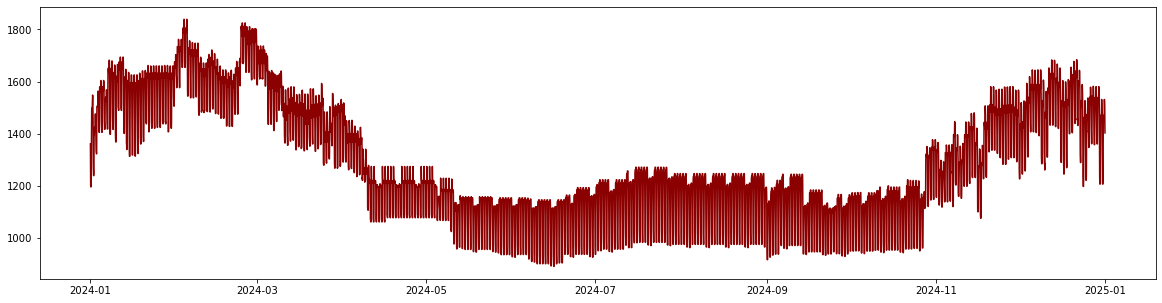

In [29]:
plt.figure(figsize=(20, 5))
plt.plot(df['prediction'], color='DarkRed')
plt.show()

## 2025 Hourly Demand Forecasting

In [30]:
# Populate Dataframe With 2025
date_range= pd.date_range(start="2025-01-01", end="2025-12-31", freq="H")
data_2025 = pd.DataFrame() 
data_2025["Date/time"]=date_range

In [31]:
df1=df1.set_index("Date/time")

In [32]:
df1=create_features(df1)

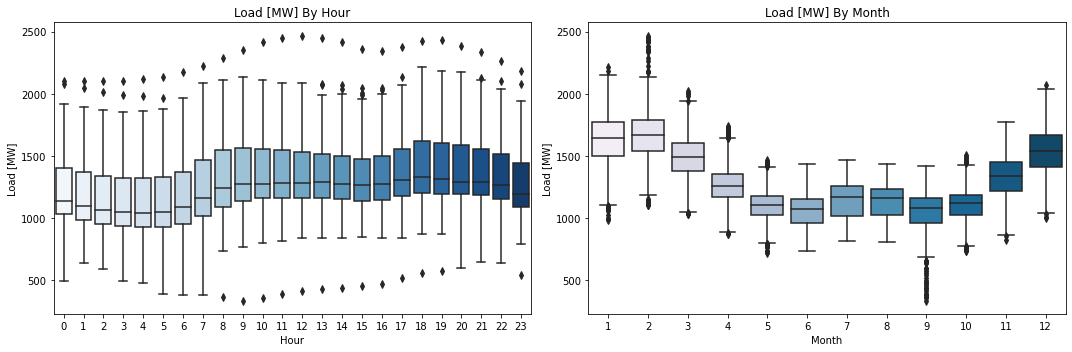

In [33]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.boxplot(data=df1,x="Hour",y="Load [MW]",palette="Blues")
plt.title("Load [MW] By Hour")
plt.ylabel('Load [MW]')


plt.subplot(1,2,2)
sns.boxplot(data=df1,x="Month",y="Load [MW]",palette="PuBu")
plt.title("Load [MW] By Month")
plt.ylabel('Load [MW]')

plt.tight_layout()
plt.show()

In [34]:
data_2025=data_2025.set_index("Date/time")

In [35]:
train=df1
test=create_features(data_2025)

In [36]:
FEATURES=['Hour', 'Day Of Week', 'Quarter', 'Month', 'Year','Day Of Year']
TARGET=['Load [MW]']

In [37]:
X_train=train[FEATURES]
y_train=train[TARGET]

X_test=test[FEATURES]


In [38]:
reg=xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50,learning_rate=0.01)
reg.fit(X_train,y_train,eval_set=[(X_train,y_train)],verbose=50)

[0]	validation_0-rmse:266.32645
[50]	validation_0-rmse:184.72755
[100]	validation_0-rmse:141.46519
[150]	validation_0-rmse:118.88625
[200]	validation_0-rmse:107.32926
[250]	validation_0-rmse:99.76848
[300]	validation_0-rmse:94.17783
[350]	validation_0-rmse:90.09169
[400]	validation_0-rmse:86.40105
[450]	validation_0-rmse:84.45588
[500]	validation_0-rmse:82.63947
[550]	validation_0-rmse:80.92814
[600]	validation_0-rmse:79.38817
[650]	validation_0-rmse:78.11043
[700]	validation_0-rmse:77.00730
[750]	validation_0-rmse:76.02234
[800]	validation_0-rmse:74.86747
[850]	validation_0-rmse:73.90970
[900]	validation_0-rmse:73.20172
[950]	validation_0-rmse:72.43796
[999]	validation_0-rmse:71.78714


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<AxesSubplot:title={'center':'Feature Importance'}>

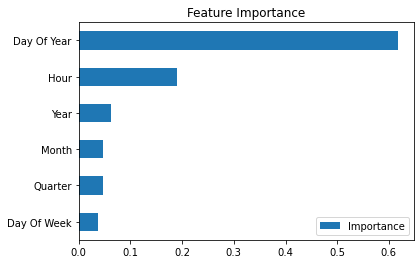

In [39]:
feature_importance=pd.DataFrame(data=reg.feature_importances_,
            index=reg.feature_names_in_,
            columns=["Importance"])

feature_importance.sort_values("Importance").plot(kind="barh",title="Feature Importance")

In [40]:
test["prediction"]=reg.predict(X_test)

In [41]:
test

,Hour,Day Of Week,Quarter,Month,Year,Day Of Year,prediction
Date/time,,,,,,,
2025-01-01 00:00:00,0,2,1,1,2025,1,1627.340332
2025-01-01 01:00:00,1,2,1,1,2025,1,1578.204590
2025-01-01 02:00:00,2,2,1,1,2025,1,1535.723145
2025-01-01 03:00:00,3,2,1,1,2025,1,1519.783447
2025-01-01 04:00:00,4,2,1,1,2025,1,1521.657349
...,...,...,...,...,...,...,...
2025-12-30 20:00:00,20,1,4,12,2025,364,1438.421509
2025-12-30 21:00:00,21,1,4,12,2025,364,1400.623413
2025-12-30 22:00:00,22,1,4,12,2025,364,1356.626221


In [43]:
frames = [df1,test]

pred_2025 = pd.concat(frames)
pred_2025

,Load [MW],Hour,Day Of Week,Quarter,Month,Year,Day Of Year,prediction
Date/time,,,,,,,,
2022-01-01 01:00:00,1289.44,1,5,1,1,2022,1,NaN
2022-01-01 02:00:00,1297.40,2,5,1,1,2022,1,NaN
2022-01-01 03:00:00,1253.83,3,5,1,1,2022,1,NaN
2022-01-01 04:00:00,1225.03,4,5,1,1,2022,1,NaN
2022-01-01 05:00:00,1215.07,5,5,1,1,2022,1,NaN
...,...,...,...,...,...,...,...,...
2025-12-30 20:00:00,NaN,20,1,4,12,2025,364,1438.421509
2025-12-30 21:00:00,NaN,21,1,4,12,2025,364,1400.623413
2025-12-30 22:00:00,NaN,22,1,4,12,2025,364,1356.626221


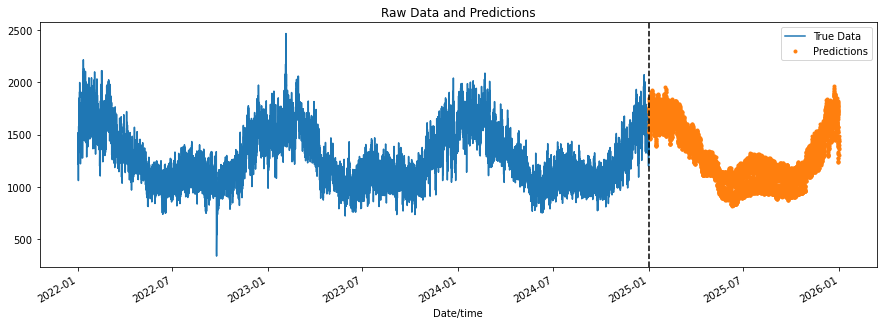

In [44]:
ax=pred_2025[["Load [MW]"]].plot(figsize=(15,5))
pred_2025['prediction'].plot(ax=ax,style='.')
plt.legend(["True Data", "Predictions"])
ax.axvline('2025-01-01 00:00:00', color='black', ls='--')
ax.set_title("Raw Data and Predictions")
plt.legend(["True Data", "Predictions"])
plt.show()

In [45]:
pred_2025

,Load [MW],Hour,Day Of Week,Quarter,Month,Year,Day Of Year,prediction
Date/time,,,,,,,,
2022-01-01 01:00:00,1289.44,1,5,1,1,2022,1,NaN
2022-01-01 02:00:00,1297.40,2,5,1,1,2022,1,NaN
2022-01-01 03:00:00,1253.83,3,5,1,1,2022,1,NaN
2022-01-01 04:00:00,1225.03,4,5,1,1,2022,1,NaN
2022-01-01 05:00:00,1215.07,5,5,1,1,2022,1,NaN
...,...,...,...,...,...,...,...,...
2025-12-30 20:00:00,NaN,20,1,4,12,2025,364,1438.421509
2025-12-30 21:00:00,NaN,21,1,4,12,2025,364,1400.623413
2025-12-30 22:00:00,NaN,22,1,4,12,2025,364,1356.626221


In [46]:
df2=pred_2025.loc[pred_2025["Year"] < 2025, ["Year", "Month","Load [MW]"]]
df3=pred_2025.loc[pred_2025["Year"] >= 2025, ["Year", "Month","prediction"]]
df3

,Year,Month,prediction
Date/time,,,
2025-01-01 00:00:00,2025,1,1627.340332
2025-01-01 01:00:00,2025,1,1578.204590
2025-01-01 02:00:00,2025,1,1535.723145
2025-01-01 03:00:00,2025,1,1519.783447
2025-01-01 04:00:00,2025,1,1521.657349
...,...,...,...
2025-12-30 20:00:00,2025,12,1438.421509
2025-12-30 21:00:00,2025,12,1400.623413
2025-12-30 22:00:00,2025,12,1356.626221


In [47]:
monthly1_avg = df2.groupby(["Year","Month"])["Load [MW]"].mean()
monthly2_avg = df3.groupby(["Year","Month"])["prediction"].mean()
frames = [monthly1_avg,monthly2_avg]

monthly_avg = pd.concat(frames, axis=0).reset_index()
monthly_avg.columns = ["Year","Month", "Value"]
monthly_avg
old=monthly_avg[monthly_avg["Year"]<2025]
new=monthly_avg[monthly_avg["Year"]>=2025]

In [48]:
old["Date"] = pd.to_datetime(old[["Year", "Month"]].assign(Day=1))
new["Date"] = pd.to_datetime(new[["Year", "Month"]].assign(Day=1))


<ipython-input-48-ede6e140d110>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  old["Date"] = pd.to_datetime(old[["Year", "Month"]].assign(Day=1))
<ipython-input-48-ede6e140d110>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new["Date"] = pd.to_datetime(new[["Year", "Month"]].assign(Day=1))


Text(0, 0.5, 'Load (MW)')

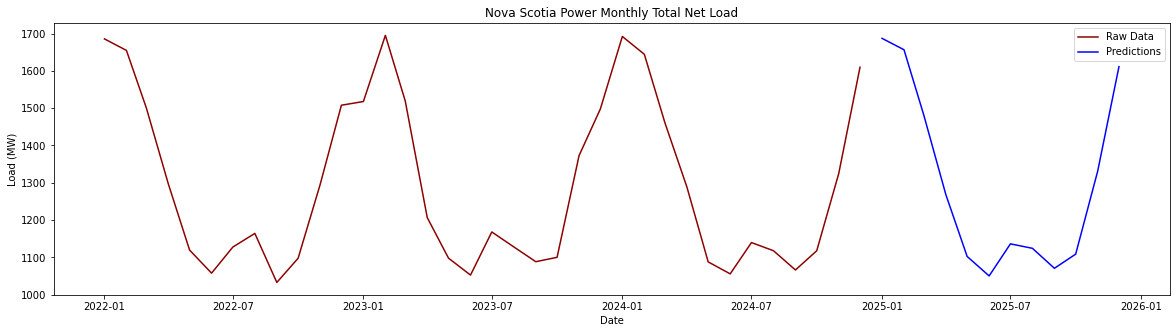

In [49]:
# Convert to numpy arrays
date1 = old['Date'].to_numpy()
date2 = new['Date'].to_numpy()
value1 = old['Value'].to_numpy()
value2 = new['Value'].to_numpy()

plt.figure(figsize=(20, 5))

# Plot the data
plt.plot(date1,value1,color='DarkRed')
plt.plot(date2,value2, color='Blue')
plt.legend(["Raw Data", "Predictions"])
# Adding the title and labels
plt.title('Nova Scotia Power Monthly Total Net Load')
plt.xlabel('Date')
plt.ylabel('Load (MW)')

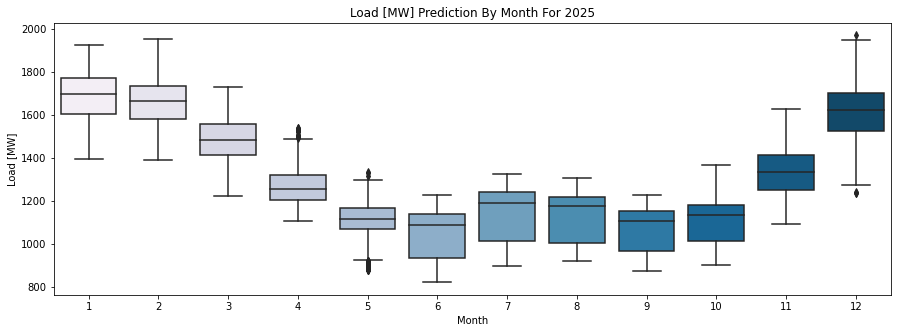

In [50]:

plt.figure(figsize=(15,5))
sns.boxplot(data=df3,x="Month",y="prediction",palette="PuBu")
plt.title("Load [MW] Prediction By Month For 2025")
plt.ylabel('Load [MW]')

plt.show()

Based on monthly predictions, 2025 will probably end up with similar demand to previous years unless if there are longer or harsher winters/summers and or other major weather events.